In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

## Gaussian Process Regression

See [my reading notes](https://www.notion.so/Michael-s-notes-and-notebooks-bc601a7b27004c259325e352e01b0753) for more theoretical details.

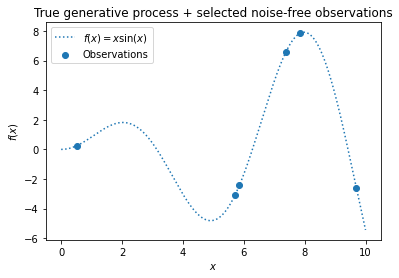

In [ ]:
# Generate the "true process" f(x) = xsin(x)
X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

# Select 6 noise-free (x, y) for the "observed data"
training_indices = np.random.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("True generative process + selected noise-free observations")
plt.show()

GP Regression depends on a kernel function to define the covariance matrix of the inputs, which is typically a function that depends only on the distance (aka Radial Basis Function) and a scaling parameters (i.e. a caracteristic lenght required for significant change of the functions in the GP prior over the function space).

`.fit()` simply computes the posterior distribution over functions, i.e. the predictive distribution conditionned on observations:


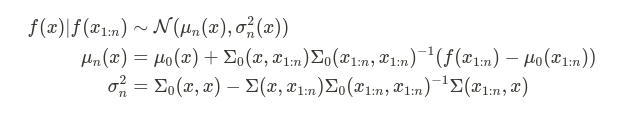

In [ ]:
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

RBF(length_scale=0.602)

Then the posterior can used to sample $f$ at any $x$. This leads to a Gaussian distribution for every $x$, and `.predict()` returns its mean (and its std_dev, optionnaly) as follows:

Text(0.5, 1.0, 'Gaussian process regression on noise-free dataset')

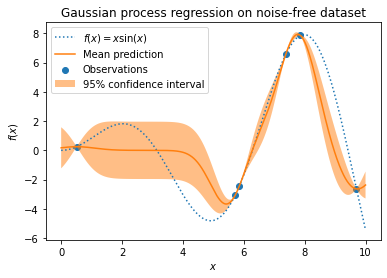

In [ ]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.title("Gaussian process regression on noise-free dataset")

## Bayes Optimization

See [my reading notes](https://www.notion.so/Michael-s-notes-and-notebooks-bc601a7b27004c259325e352e01b0753) for more theoretical details.

In [ ]:
! pip install scikit-optimize
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize
from skopt.plots import plot_convergence

We're trying to solve $x^* = \text{arg min} f(x)$ with $f(x) = \sin (5x)  - \tanh (2x) + 1$ that can 

In [ ]:
# Define the function to minimize
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

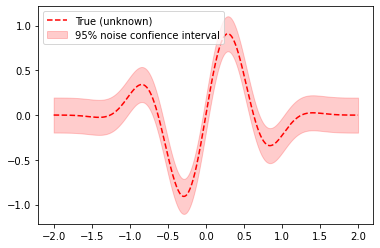

In [ ]:
x = np.linspace(-2, 2, 400)#.reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x.reshape(-1, 1)]
plt.plot(x, fx, "r--", label="True (unknown)")

plt.fill_between(
    x,
    [fx_i - 1.96 * noise_level for fx_i in fx],
    [fx_i + 1.96 * noise_level for fx_i in fx],
    alpha=0.2, 
    color='red',
    label='95% noise confience interval'
)
plt.legend()

`skopt.plots.plot_gaussian_process` is the class that does the Bayes Optimization `n_calls` iterations from `n_random_starts` random evaluations of the target function `f`. It uses the acquisition function with `acq_func` with choices :

- `='EI'` for ***expected improvement*** $EI(x) = \mathbb{E}[f(x) - f(x_t^+)]$ (with $x_t^+$ being the best estimation so far for argmin).
- `='LCB'` for ***lower confidence bound*** $LCB(x) = \mu_{GP}(x) + \kappa\sigma_{GP}(x)$ with $\kappa$ controlling the exploration-exploitation trade-off (exploitation is where we evaluate on low $\mu_{GP}(x)$ and exploration where the uncertainty is high $\sigma_{GP}(x)$
- `='PI'` for ***probability of improvement*** $PI(x) = P(f(x) \geq f(x_t^+) + \kappa)$ (same definitions for $\kappa$ and $x_t^+$).

In [ ]:
res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="PI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)  # the random seed

After 15 iterations with 5 random evaluations in the (-2, 2) domain, the Bayes optimization with the expected improvement acquisition function leads to the following evalution:

In [ ]:
f"x^*={res.x[0]}, f(x^*)={res.fun}"

'x^*=-0.3456944141273359, f(x^*)=-0.9425939701072688'

The Class `skopt.gp_minimize` keeps in memory the iterative evaluations:

In [ ]:
print(res)

          fun: -0.9425939701072688
    func_vals: array([ 0.0474957 ,  0.00991258,  0.54250557, -0.07199282,  0.08280101,
       -0.94259397, -0.11257863, -0.83722624, -0.87364034, -0.0708674 ,
        0.04390307, -0.00415651, -0.82916718,  0.38185779,  0.06990918])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True

`scikit-optimize`'s `skopt.plots.plot_gaussian_process` takes `skopt.gp_minimize` as an argument and performs the interation itself, and offers nice visualization in the process:

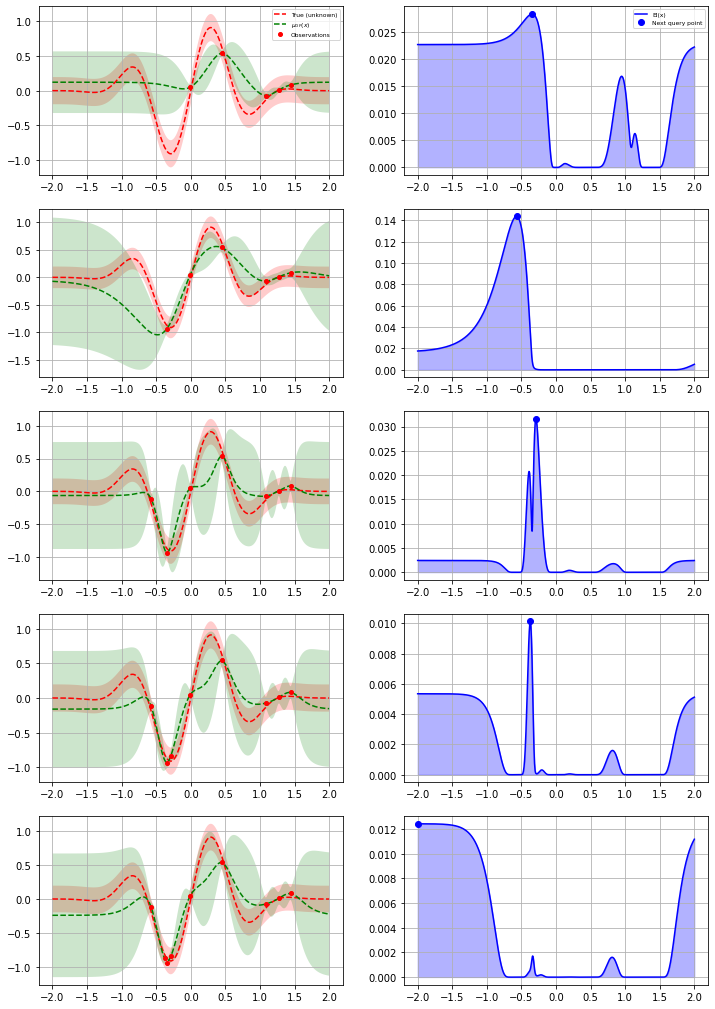

In [ ]:

def f_wo_noise(x):
    return f(x, noise_level=0)

plt.rcParams["figure.figsize"] = (12, 18)


for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, 
                               n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, 
                               show_title=False,
                               show_next_point=False, 
                               show_acq_func=False,
                               show_mu=True             # Shows the posterior's mean
                               )
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, 
                               n_calls=n_iter,
                               show_legend=show_legend, 
                               show_title=False,
                               show_acq_func=True,
                               show_observations=False,
                               show_next_point=True,
                               show_mu=False)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

`skopt.plots.plot_convergence` also takes a fitted `gp_minimize` to show the convergence rate

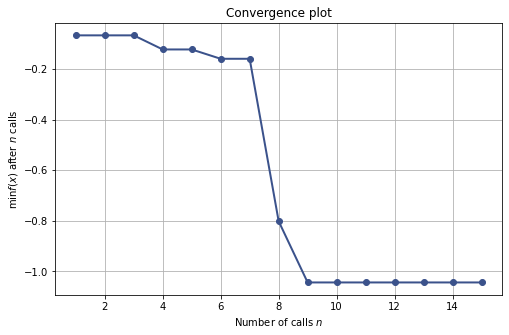

In [ ]:
plt.rcParams["figure.figsize"] = (8, 5)
plot_convergence(res)

# Active Learning

TODO